# Simulate distinct levels of batch effects (integration success) with splatter
Inspiration by Andreatta et al., 2024 and https://github.com/Oshlack/splatter/issues/99


- Nested batch effects 4 samples from 2 studies (batches) with two samples each, with samples within studies being more similar to each other than between studies.
- 3 cell types with varying proportions and distance between cell types

Scenarios:
- Mild (good integration)
- Intermediate (poor integration - strong batch effects)
- Strong (no integration)
- None (perfect integration)
- Overcorrected (poor integration - overcorrection)

Run on maxg16

In [1]:
# Load package
suppressPackageStartupMessages({
    library(splatter)
    library(scater)
    library(data.table)
    library(ggplot2)
    library(gridExtra)
})

In [2]:
packageVersion('splatter')

[1] ‘1.26.0’

In [2]:
simulate_batch_effects <- function(scenario, batch.facLocGroup1, batch.facScaleGroup1, overcorrected=FALSE){
    set.seed(4514457)
    params <- newSplatParams()
    params <- setParam(params, "nGenes", 1000)

    if (overcorrected) {
        de.prob <- c(0.0, 0.0, 0.0)
    } else {
        de.prob <- c(0.01, 0.02, 0.05)
    }

    sim.groups <- splatSimulate(
        params,
        batchCells = c(2000, 2000),
        group.prob = c(0.2, 0.3, 0.5),
        de.prob = de.prob,
        batch.facLoc = batch.facLocGroup1,
        batch.facScale = batch.facScaleGroup1,
        method = "groups",
        verbose = FALSE
    )

    params <- setParam(params, "batchCells", 2000)
    params <- setParam(params, "lib.scale", 1)
    params <- setParam(params, "lib.loc", 0.2)

    sim.groups2 <- splatSimulate(
        params,
        method = "groups",
        verbose = FALSE
    )

    # Rename cell types
    names(colData(sim.groups))[which(names(colData(sim.groups))=="Group")] <- "Cell_type"

    # Introduce groups
    colData(sim.groups)$Group <- colData(sim.groups)$Cell_type

    colData(sim.groups)$Cell_type <- ifelse(colData(sim.groups)$Cell_type == "Group1", "Cell_type1",
                          ifelse(colData(sim.groups)$Cell_type == "Group2", "Cell_type2",
                                 ifelse(colData(sim.groups)$Cell_type == "Group3", "Cell_type3",
                                 colData(sim.groups)$Cell_type)))

    # Rename samples
    colData(sim.groups)$Batch <- ifelse(colData(sim.groups)$Batch == "Batch1", "Sample1",
                          ifelse(colData(sim.groups)$Batch == "Batch2", "Sample3",
                                 colData(sim.groups)$Batch))


    # We simulated two batches with batch effects between them, which we named Sample1 and Sample3
    # Now, we add a small amout of noise to ~half of the cells from both of these Samples, simulating an additional smaller batch effect 
    # resulting in overall four samples, with small batch effects between pairs of them and large between those pairs
    # Sample1 + small amount of noise == Sample2
    # Sample3 + small amount of noise == Sample4
    # Sample1+2 are similar to each other
    # Sample3+4 are similar to each other
    # We simulate varying strength of batch effects between the Sample1+2 pair and the Sample3+4 pair
    # Select every second column from sim.groups
    
    # We do not modify sim.groups_subset1
    selected_columns1 <- seq(1, ncol(sim.groups), by = 2)
    sim.groups_subset1 <- sim.groups[, selected_columns1]

    # We add small amount of noise to sim.groups_subset
    selected_columns <- seq(2, ncol(sim.groups), by = 2)
    sim.groups_subset <- sim.groups[, selected_columns]


    # Rename batch information in the subset
    colData(sim.groups_subset)$Batch <- ifelse(colData(sim.groups_subset)$Batch == "Sample1", "Sample2",
                                                    ifelse(colData(sim.groups_subset)$Batch == "Sample3", "Sample4",
                                                           colData(sim.groups_subset)$Batch))
    
    if (scenario != overcorrected & scenario != "None") {
            assay(sim.groups_subset, "counts") <- assay(sim.groups_subset, "counts") + assay(sim.groups2, "counts")
    }



    # Combine the unmodified and modified subset
    sce <- cbind(sim.groups_subset1, sim.groups_subset)
    
    # Save
    # 1. Save counts matrix
    counts_matrix <- counts(sce)
  
    # Convert sparse matrix to regular matrix
    counts_matrix <- as.matrix(counts_matrix)
  
    counts_df <- as.data.frame(counts_matrix)

    # Save counts as CSV
    fwrite(counts_df, sprintf("data/simulated/counts_matrix_%s.csv", scenario))

    # 2. Save column metadata
    col_data <- as.data.frame(colData(sce))

    # Add cell names as a column
    col_data$cell_id <- colnames(sce)

    # Reorder columns to have cell_id as the first column
    col_data <- col_data[, c("cell_id", setdiff(colnames(col_data), "cell_id"))]

    # Save column metadata as CSV
    fwrite(col_data, sprintf("data/simulated/cell_metadata_%s.csv", scenario))

    
    # Visualize                                      
    sce <- logNormCounts(sce)
    sce <- runPCA(sce)
    par(mfrow = c(3, 1))
    p1 <- plotPCA(sce, shape_by = "Cell_type", colour_by = "Batch")
    p2 <- plotPCA(sce, colour_by = "Batch")
    p3 <- plotPCA(sce, colour_by = "Cell_type")
    grid.arrange(p1, p2, p3,  nrow = 3)
    
}

Warning message in with_preserve_seed({:
“nGroups is 1, switching to single mode”
Warning message in with_preserve_seed({:
“nGroups is 1, switching to single mode”


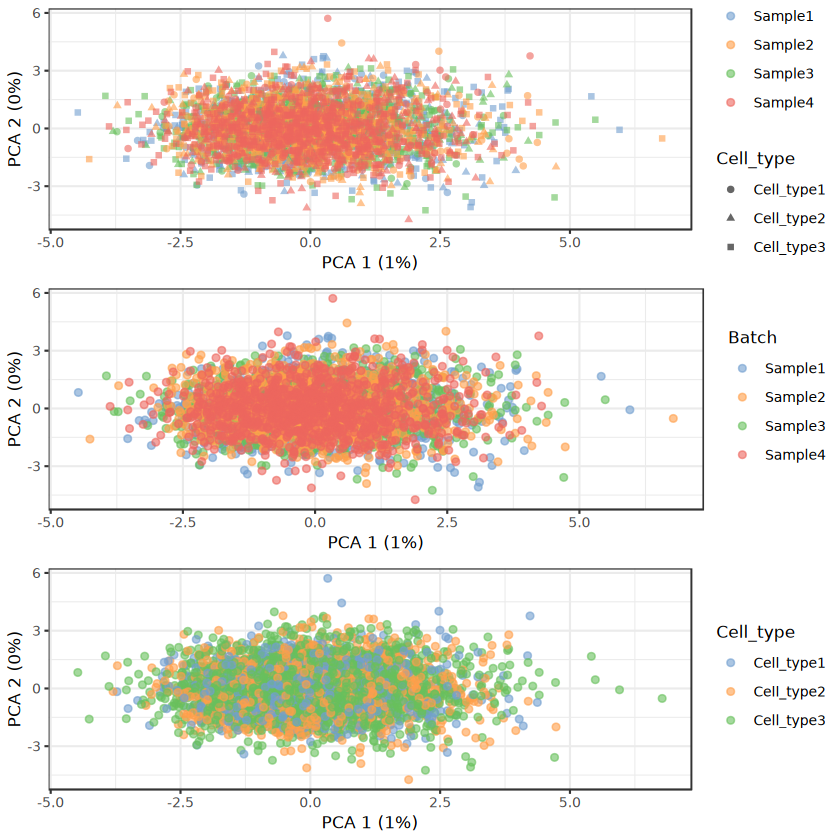

Warning message in with_preserve_seed({:
“nGroups is 1, switching to single mode”


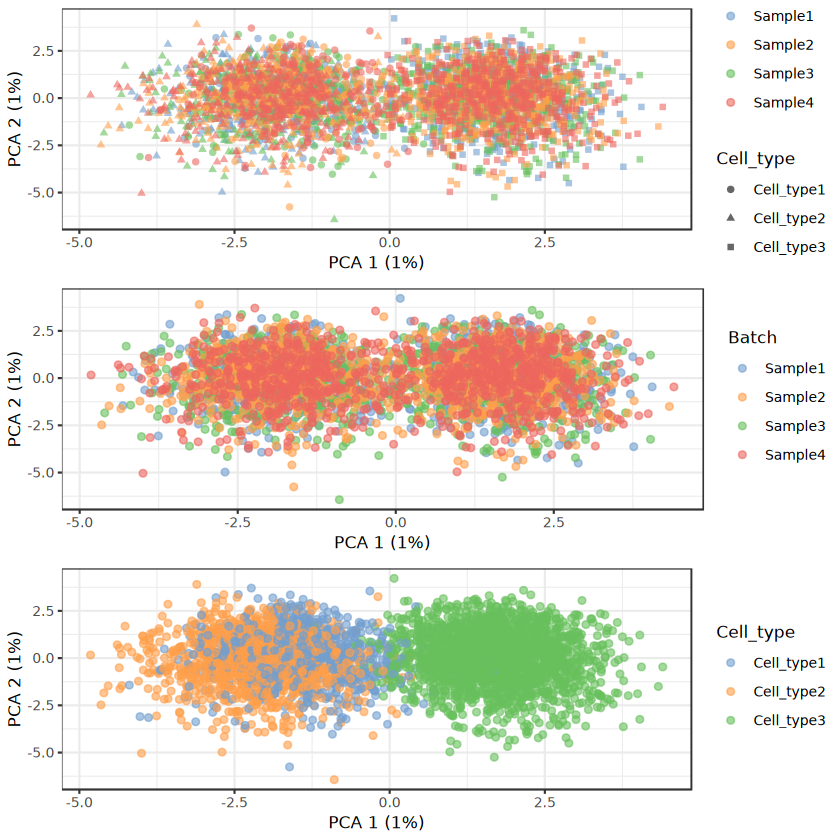

Warning message in with_preserve_seed({:
“nGroups is 1, switching to single mode”


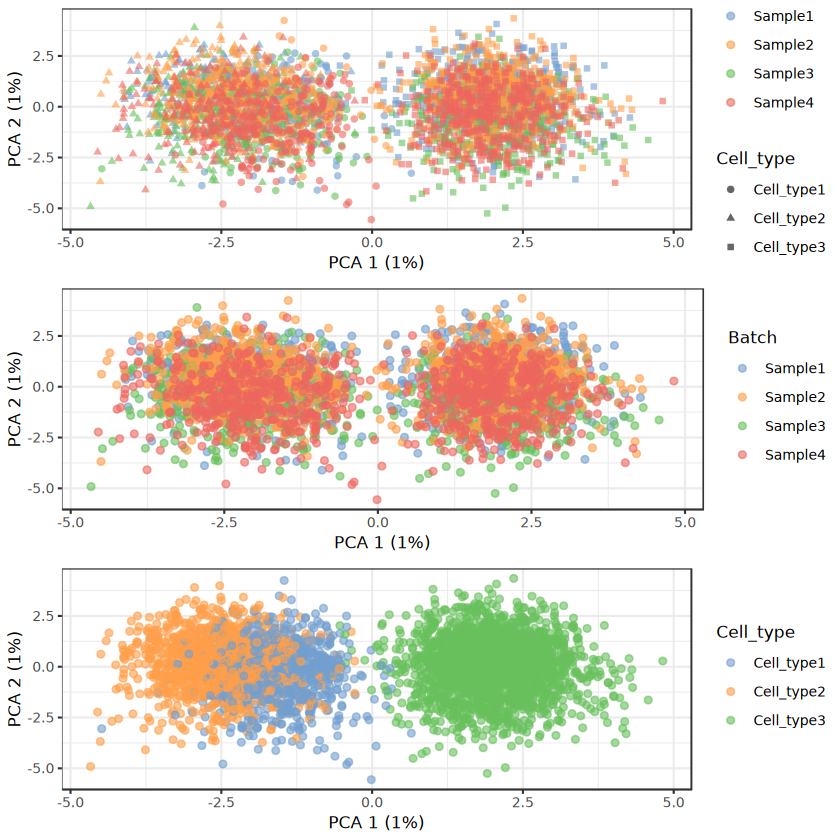

Warning message in with_preserve_seed({:
“nGroups is 1, switching to single mode”


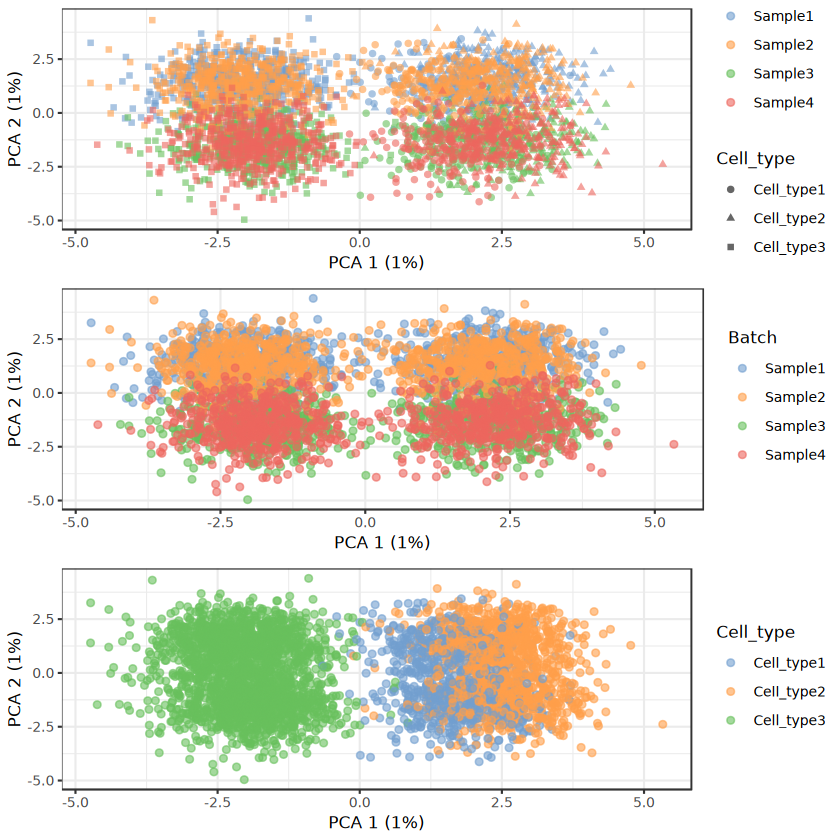

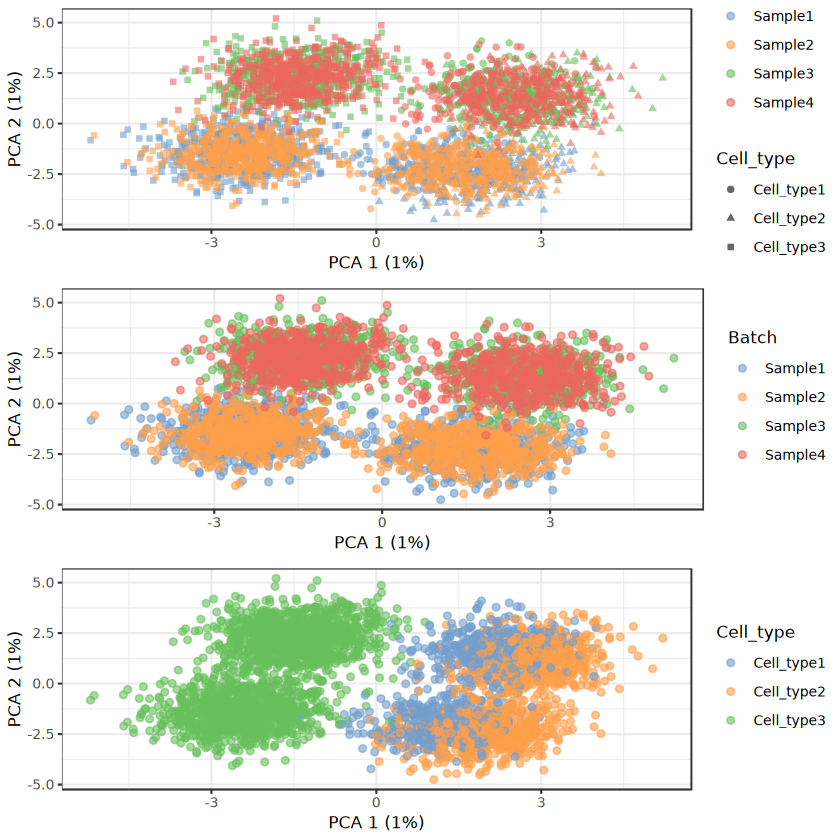

In [3]:
simulate_batch_effects("Overcorrected", 0.00, 0.00, TRUE)

simulate_batch_effects("None", 0.00, 0.00)

simulate_batch_effects("Mild", 0.03, 0.03)

simulate_batch_effects("Intermediate", 0.045, 0.045)

simulate_batch_effects("Strong", 0.06, 0.06)